# Cas Kaggle
## GPU Kernel Performance

Cristina Soler Arenys 

NIU: 1603542

### Introducció

![A](pictures/tune.png)

Aquest conjunt de dades mesura el temps d'execució d'un producte matriu-matriu A · B = C. Totes les matrius tenen una mida de 2048 x 2048, utilitzant un nucli de GPU SGEMM parametrizable amb 241600 combinacions de paràmetres possibles.

Per a cada combinació provada, es van realitzar 4 execucions i els seus resultats es presenten com a les 4 darreres columnes. Tots els temps es mesuren en mil·lisegons. L'experiment es va executar en una estació de treball d'escriptori amb Ubuntu 16.04 Linux amb un Intel Core i5 (3,5 GHz),16 GB de RAM i una GPU NVidia Geforce GTX 680 4 GB GF580 GTX-1,5 GB.

Les variables que ens proporciona el dataset, són aquelles marcades a la imatge anterior, juntament amb propietats dels processadors.

#### Informació dels atributs:

Independent variables:
    
1. `MWG`: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
    
2. `NWG`: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
   
3. `KWG`: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
    
4. `MDIMC`: local workgroup size also defines the amount of work-per-thread in M dimensions: {8, 16, 32} (integer)
    
5. `NDIMC`: local workgroup size also defines the amount of work-per-thread in N dimensions: {8, 16, 32} (integer)
    
6. `MDIMA`: local memory shape: {8, 16, 32} (integer)
    
7. `NDIMB`: local memory shape: {8, 16, 32} (integer)
    
8. `KWI`: kernel loop unrolling factor: {2, 8} (integer)
    
9. `VWM`: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
    
10. `VWN`: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
    
11. `STRM`: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
    
12. `STRN`: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
    
13. `SA`: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

14. `SB`: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)
    
Output:
    
15-18. `Run1`, `Run2`, `Run3`, `Run4`: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

## Llibreries usades

In [57]:
#importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import time
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV,  ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, KFold ,cross_val_predict, StratifiedKFold, learning_curve, train_test_split, LeaveOneOut, RepeatedStratifiedKFold

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sk

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import arange

# Standardizing the features
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

## Descripció de les dades

Importem el dataset i mirem l'estructura de les dades

In [308]:
train_df = pd.read_csv('sgemm_product.csv', header=0, delimiter=',')
train_df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [309]:
print(train_df.info())
print("")
print("--------------------------------------")
print("")
print("Number of Nulls")
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB
None

-----------

Mirem la informació bàsica del dataset. On podem veure que conté 241600 entrades, en 18 columnes sense cap valor nul.

In [60]:
train_df.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


Mirem les distribucions de les dades donades:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A441BD8CD0>,
      dtype=object)

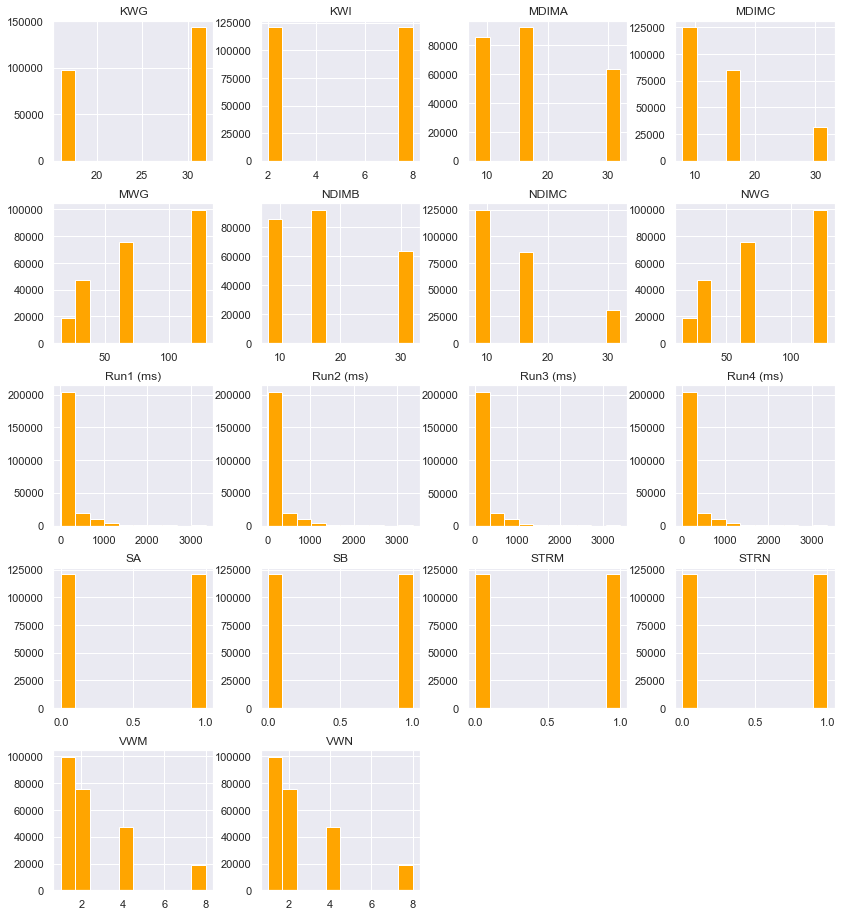

In [310]:
sns.set()
sns.color_palette("blend:#7AB,#EDA", as_cmap=True)
train_df.hist(figsize=(14,16), color='orange')

Veiem que a la majoria de dades tenim 4 o 3 columnes diferents i allà es concentren tots els nostres valors, així que a partir `pieplots` mirem quin valor predomina en cada columna.

In [62]:
desfase = (0.1, 0, 0, 0)
colores = ["#EE6055","#60D394","#AAF683","#FFD97D","#FF9B85"]

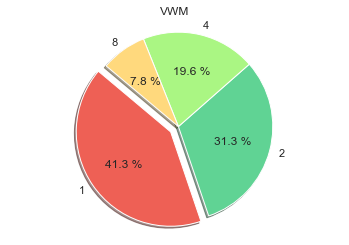

In [63]:
plt.pie(train_df['VWM'].value_counts(), labels= train_df['VWM'].unique(), colors=colores, autopct="%0.1f %%", explode=desfase, shadow=True, startangle=140)
plt.axis("equal")
plt.title("VWM")
plt.show()

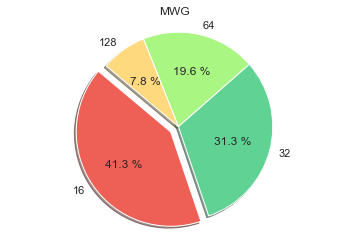

In [64]:
plt.pie(train_df['MWG'].value_counts(), labels= train_df['MWG'].unique(), colors=colores, autopct="%0.1f %%", explode=desfase,shadow=True, startangle=140)
plt.axis("equal")
plt.title("MWG")
plt.show()

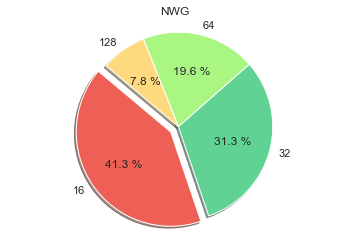

In [65]:
plt.pie(train_df['NWG'].value_counts(), labels= train_df['NWG'].unique(), colors=colores, autopct="%0.1f %%", explode=desfase, shadow=True, startangle=140)
plt.axis("equal")
plt.title('NWG')
plt.show()

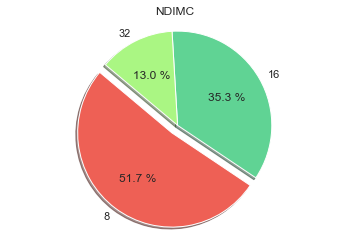

In [66]:
desfase = (0.1, 0, 0)
plt.pie(train_df['NDIMC'].value_counts(), labels= train_df['NDIMC'].unique(), colors=colores, autopct="%0.1f %%", explode=desfase, shadow=True, startangle=140)
plt.axis("equal")
plt.title('NDIMC')
plt.show()

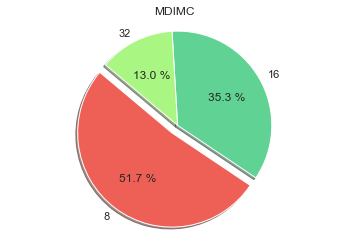

In [67]:
desfase = (0.1, 0, 0)
plt.pie(train_df['MDIMC'].value_counts(), labels= train_df['MDIMC'].unique(), colors=colores, autopct="%0.1f %%", explode=desfase, shadow=True, startangle=140)
plt.axis("equal")
plt.title('MDIMC')
plt.show()

A més a més, també visualitzem les dades categòriques.

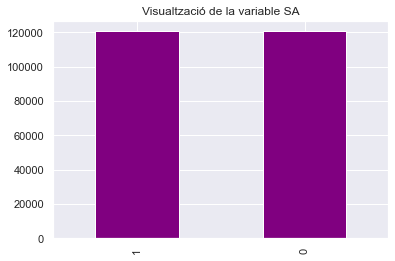

In [68]:
plot = train_df['SA'].value_counts().plot(kind='bar', title='Visualtzació de la variable SA', color ="purple")

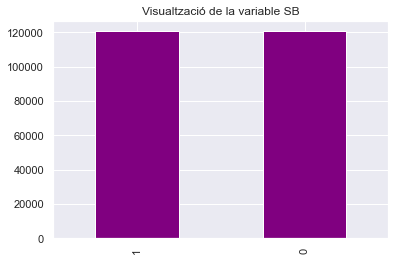

In [69]:
plot = train_df['SB'].value_counts().plot(kind='bar', title='Visualtzació de la variable SB', color ="purple")

Per finalitzar mostrem la correlació actual de les dades:

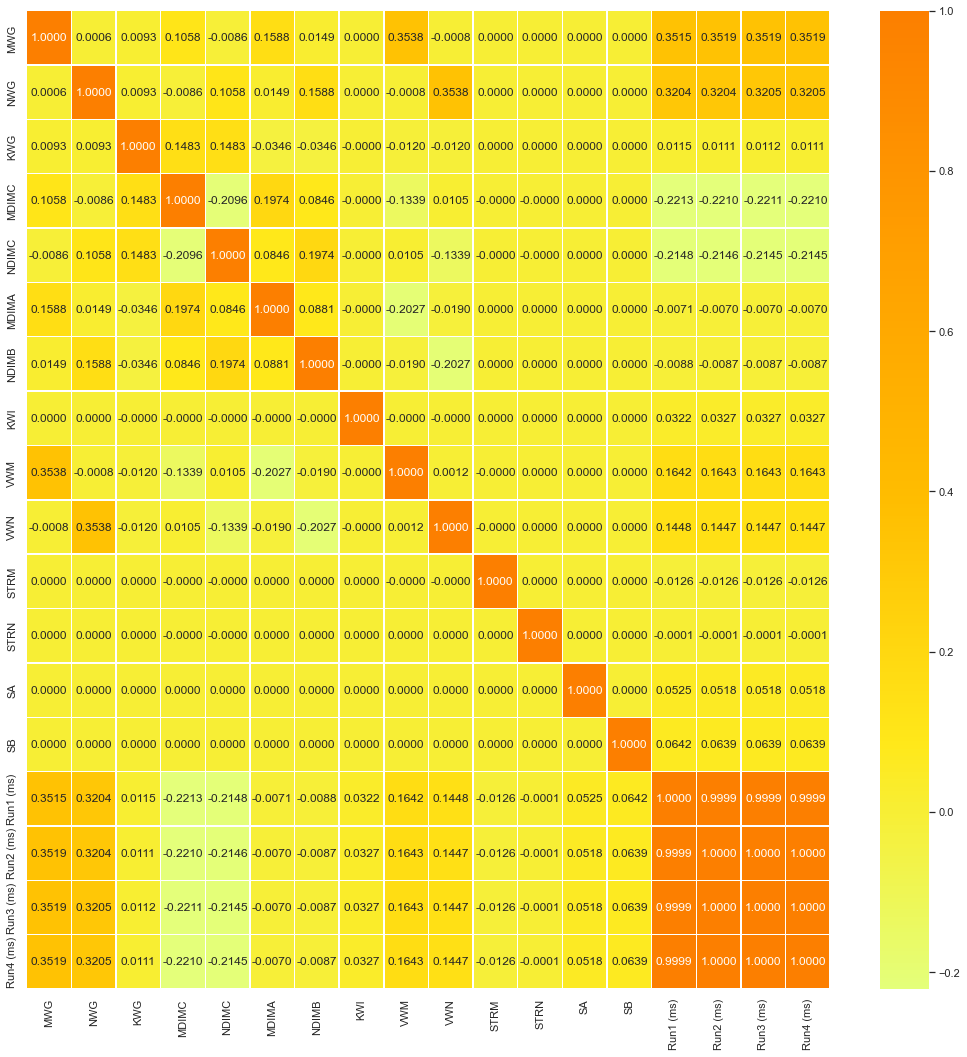

In [70]:
f,ax = plt.subplots(figsize=(18,18))
sns.heatmap(train_df.corr(),annot=True,linewidths=.5,fmt='.4f',ax=ax, cmap="Wistia")
plt.show()

Com podem veure les diferents execucions tenen una alta correlació entre elles, i entre les variables tenen més o menys la mateixa correlació. D'aquí podríem extreure que els temps d'execució són consistents entre ells, i no tenim temps molt diferents en una sola combinació de components.

## Pre-procesament

#### Variable Objectiu

Com ens diu la descripció de les dades, tenim 4 execucions de temps diferents per la combinació de dades obtinguda ('Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)' i 'Run4 (ms)'). Per tant, per treballar millor extrèiem el temps mitjà d'execució entre les 4 dades i creem una variable nova anomenada 'Runtime'.

In [71]:
train_df['Runtime'] = train_df[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)

In [72]:
train_df = train_df.drop(['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'], axis = 1)

#### Eliminació de Outliers

Mirem si tenim outliers a les dades, per eliminar-los i evitar problemes a l'hora de predir i millorar els resultats. Per detectar-los aplicarem el mètode del `Z-score`, bàsicament compararem les dades a partir de la desviació estàndard  i eliminarem aquelles dades on el `Z-score` sigui superior a un llindar establert.


Primerament, mostrem els `boxplots` de les variables per mirar quines podrien contenir outliers.

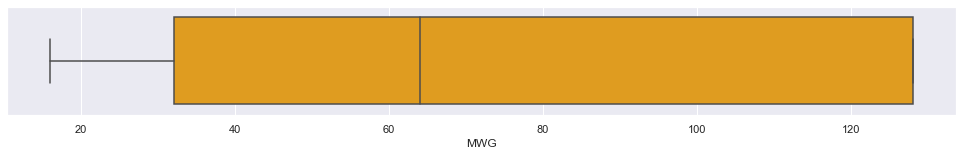

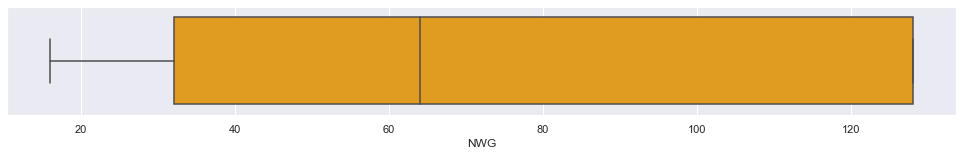

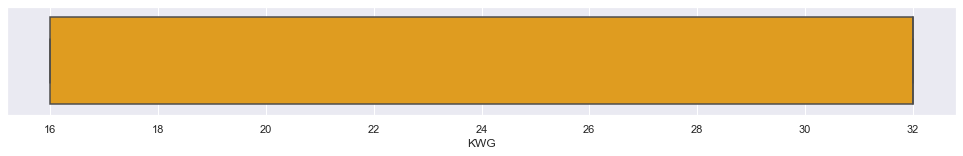

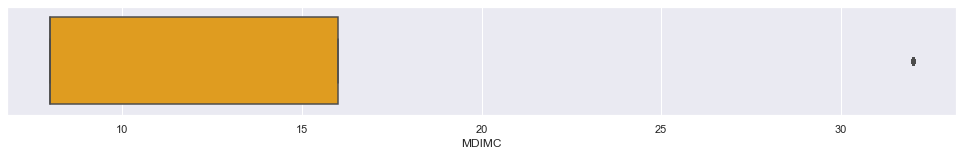

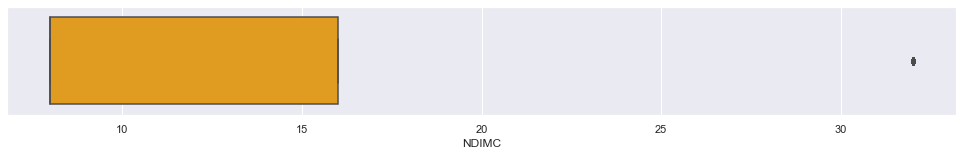

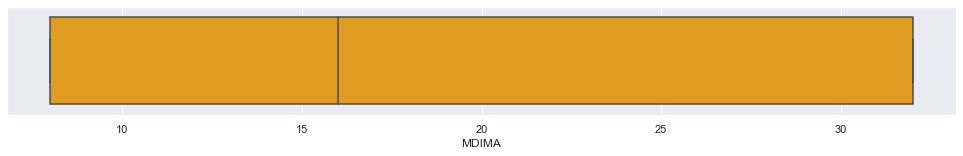

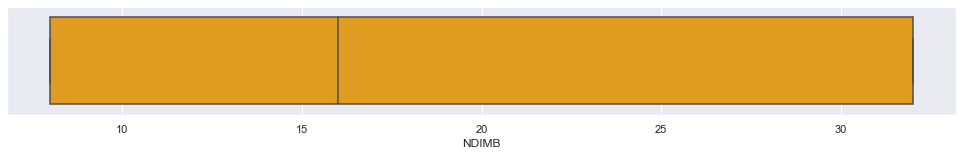

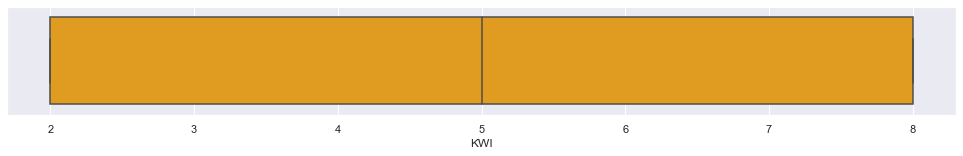

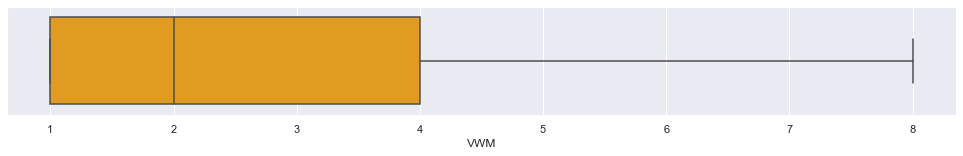

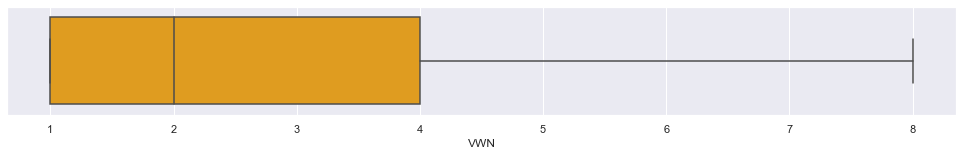

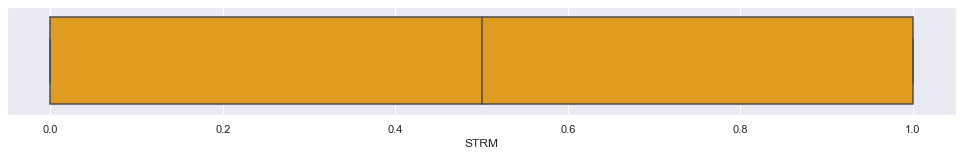

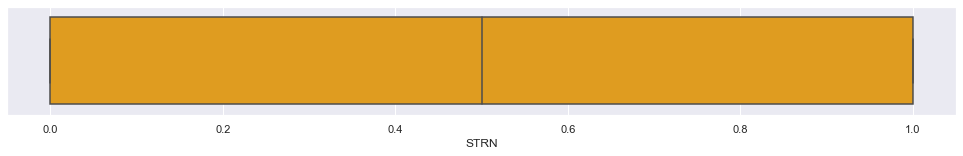

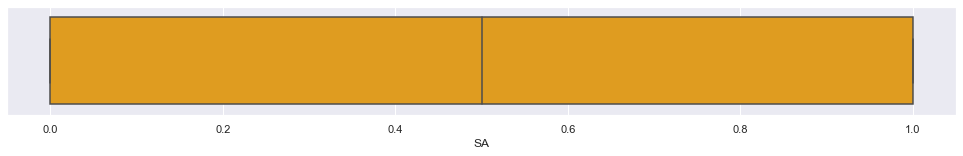

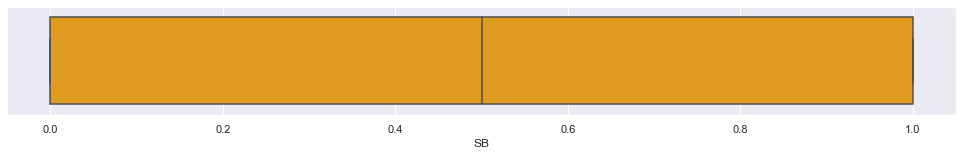

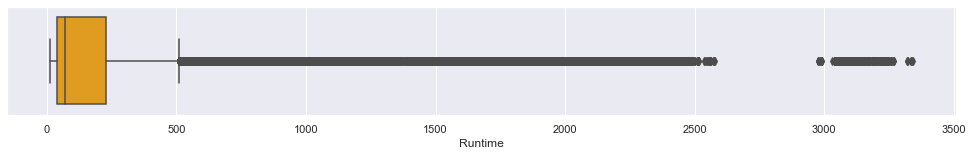

In [73]:
for column in train_df:
        plt.figure(figsize=(17,2))
        sns.boxplot(data=train_df, x=column, color='orange')

A partir de les gràfiques anteriors veiem que les dades que podrien contenir outliers són:
- `MDIMC`
- `MDINC`
- `Runtime`

Per tant, avaluem amb la `Z-score`, també anomenada estàndard score, quants outliers hem de traure per variable. El seu funcionament és el següent:

Ens ajuda a entendre si les dades són més gran o més petites que la mitjana i com de lluny estan d'aquesta. Més específicament, `Z-score` ens diu a quanta desviació estan les dades de la mitjana. Si aquesta distància és superior a 3, ens indica que els punts de les dades són diferents de les altres, i que podrien ser un outlier.

In [74]:
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    index = 0
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        index = index + 1
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(index)
    return outliers# Driver code

In [75]:
sample_outliers = detect_outliers_zscore(train_df['MDIMC'])
print("Outliers from Z-scores method: ", len(sample_outliers))

Outliers from Z-scores method:  0


In [76]:
sample_outliers = detect_outliers_zscore(train_df['NDIMC'])
print("Outliers from Z-scores method: ", len(sample_outliers))

Outliers from Z-scores method:  0


In [77]:
sample_outliers_Runtime = detect_outliers_zscore(train_df['Runtime'])
print("Outliers from Z-scores method: ", len(sample_outliers_Runtime))

Outliers from Z-scores method:  5251


Com poden veure `Runtime` és la única variable de la qual hem d'eliminar outliers:

In [78]:
train_df.drop(sample_outliers_Runtime , inplace = True)

In [79]:
train_df.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Runtime
count,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000
mean,79.571278,79.554489,25.432289,14.067773,14.067637,17.374374,17.372648,4.997322,2.429805,2.431041,0.499972,0.500074,0.503307,0.506979,196.035357
std,42.418510,42.412004,7.870757,7.910227,7.910262,9.386976,9.385887,3.000005,1.937396,1.939684,0.500001,0.500001,0.499990,0.499952,313.076324
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.317500
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.342500
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,67.952500
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,213.060000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,2490.105000


Les mètriques de les dades han millorat després de l'eliminació dels outliers, per tant ara podem treballar correctament amb el dataset. Mirem doncs, com ens quedaria la correlació de les dades amb els canvis fets fins ara.

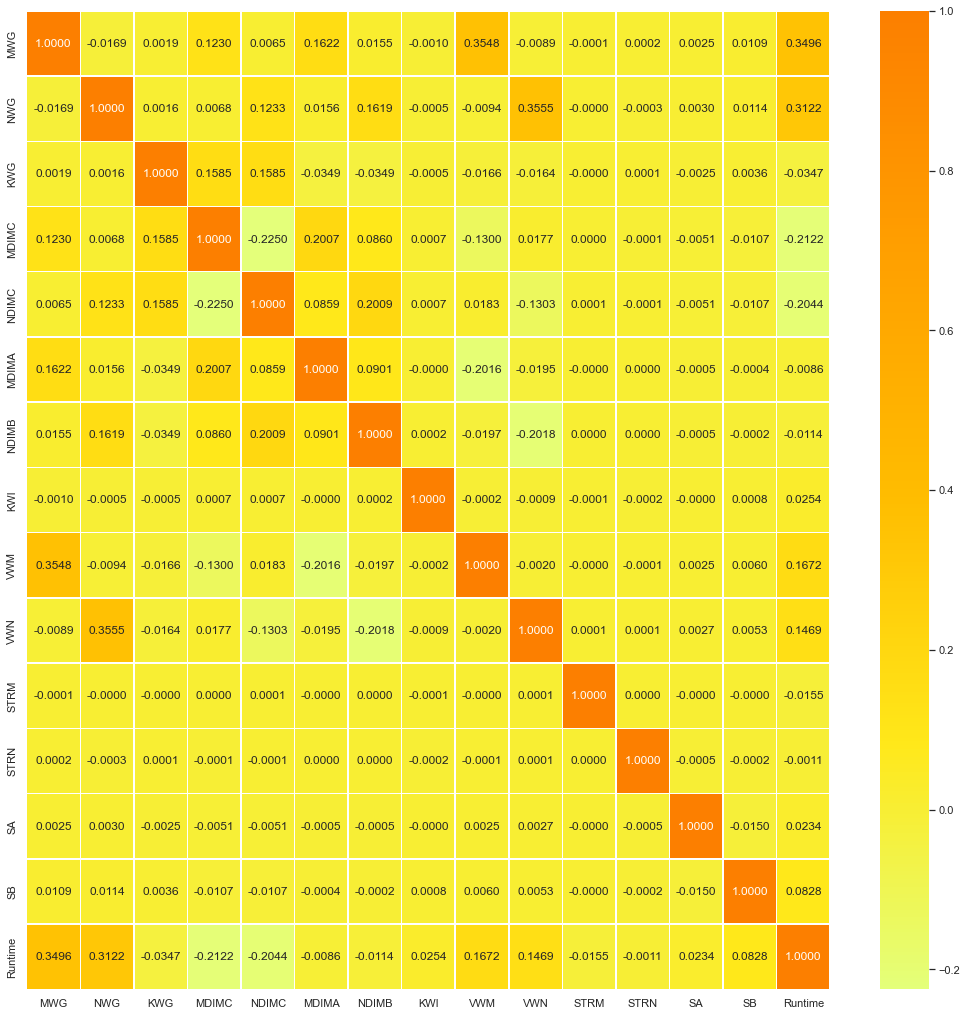

In [80]:
f,ax = plt.subplots(figsize=(18,18))
sns.heatmap(train_df.corr(),annot=True,linewidths=.5,fmt='.4f',ax=ax, cmap="Wistia")
plt.show()

#### Transformació de la variable objectiu

Per arribar a la millor distribució, apliquem una transformació logarítmica, ja que millora la distribució i l'acosta més cap a una normal, la qual ens facilitarà l'avaluació dels models i probablement millorarà els resultats. Com podem veure la distribució inicial de `Runtime` segueix una distribució exponencial:

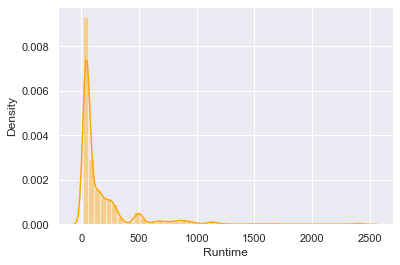

In [81]:
sns.distplot(train_df['Runtime'], color='Orange')

In [82]:
train_df['Target']=np.log(train_df.Runtime)

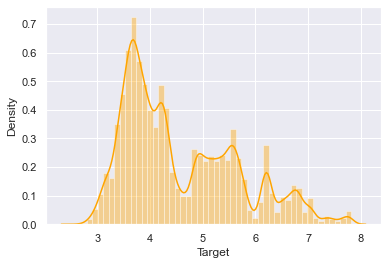

In [83]:
sns.distplot(train_df['Target'], color='Orange')

In [84]:
train_df.drop(columns = "Runtime", inplace = True)

In [85]:
train_df.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Target
count,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000,236349.000000
mean,79.571278,79.554489,25.432289,14.067773,14.067637,17.374374,17.372648,4.997322,2.429805,2.431041,0.499972,0.500074,0.503307,0.506979,4.574788
std,42.418510,42.412004,7.870757,7.910227,7.910262,9.386976,9.385887,3.000005,1.937396,1.939684,0.500001,0.500001,0.499990,0.499952,1.087675
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.589079
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.697406
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,4.218809
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,5.361574
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,7.820080


Com hem canviat la distribució del valor objectiu, mirem la correlació dels predictors amb l'objectiu:

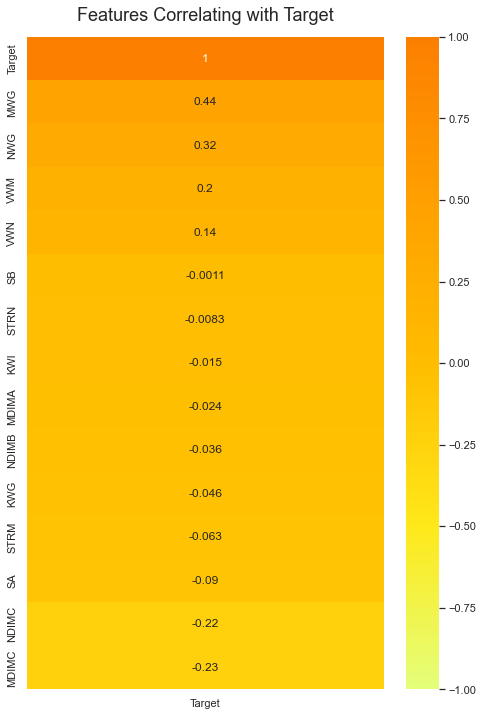

In [86]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_df.corr()[['Target']].sort_values(by='Target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Wistia')
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);

#### Creació de noves variables i encoders:

L'objectiu és crear les millors variables per trobar una bona correlació, entre els predictors i la variable `Target`. Per fer-ho he investigat sobre el tema, de les diferents variables que ens donen es poden extreure noves columnes a partir d'una combinació de dades. A partir de la informació trobada, podem afegir diverses variables a partir de la multiplicació d'altres tal com ens indica la figura del principi del nootebook. Aquestes noves variables serien:

- `MWI` = `MWG` / `MDIMC`
- `NWI` = `NWG`/ `MDIMC`
- `Prework` = `NWG` * `MWG`


A més a més, s'ha aplicat un onehot encoder aquelles dades categòriques.

In [87]:
df = train_df.copy()

In [88]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['SA', 'SB','STRM', 'STRN'])

In [89]:
df = one_hot_encoded_data.copy()

In [90]:
prework = df['NWG']*df['MWG']
df['prework'] = prework

La terminació WI es una abreviació de workitem (thread)

In [211]:
df["MWI"] = df["MWG"]/df["MDIMC"]
df['NWI'] = df["NWG"]/df["NDIMC"]

In [212]:
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,Target,SA_0,SB_0,SB_1,STRM_0,STRN_0,STRN_1,prework,MWI,NWI
0,16,16,16,8,8,8,8,2,1,1,4.756775,1,1,0,1,1,0,256,2.0,2.0
1,16,16,16,8,8,8,8,2,1,1,4.365707,1,0,1,1,1,0,256,2.0,2.0
2,16,16,16,8,8,8,8,2,1,1,4.389064,0,1,0,1,1,0,256,2.0,2.0
3,16,16,16,8,8,8,8,2,1,1,4.461733,0,0,1,1,1,0,256,2.0,2.0
4,16,16,16,8,8,8,8,2,1,1,4.776283,1,1,0,1,0,1,256,2.0,2.0


Evaluem la correlació:

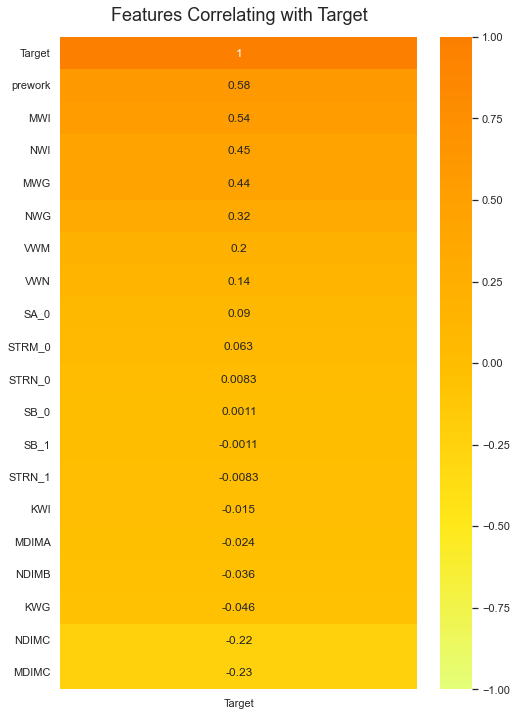

In [213]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Target']].sort_values(by='Target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Wistia')
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);

## Model learning

L'objectiu del problema és predir el temps que tardarà executar-se el programa en les condicions donades del processador.

Hem separat els conjunts en `Train-Test`, ho farem amb la proporció 70% - 30%. Per millorar els resultats del model el que farem és una validació creuada (`Crossvalidation`), el que ens ajudarà a trobar un millor model ràpidament.

### Lasso Feature selection

A partir de la regressió Lasso buscarem quins són aquells coeficients amb més importància al model, d'aquesta manera reduirem atributs amb els que treballarem.

#### Regressió Lasso:

El model `Lasso`, és un model lineal que penalitza la suma del valor absolut dels coeficients de la regressió. Aquesta penalització es coneguda com `L1` i té l'efecte de forçar a que els coeficients dels predictors tendeixin a 0. Donat que un predictor amb coeficient de regressió cero no influeix en el model, `Lasso` aconseguiex excloure els predictors menys rellevants.

El grau de penalització ve donat per l'hiperparàmetre $\alpha$, si el seu valor és 0 equival a un model lineal per mínims quadrats. A mesura que augumenta major es la penalització i més predictors queden exclosos.

In [214]:
X = df.drop(columns=['Target'])
y = df['Target'].values

In [215]:
features = X.columns

In [216]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.30)

In [217]:
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ('model', Lasso())
])

In [218]:
search = GridSearchCV(pipeline,
                     {'model__alpha':np.arange(0.001,1,0.1)},
                     cv = 5,
                     scoring = 'neg_mean_squared_error',
                     verbose = 3
                     )

In [219]:
search.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...............model__alpha=0.001;, score=-0.408 total time=   0.6s
[CV 2/5] END ...............model__alpha=0.001;, score=-0.410 total time=   0.6s
[CV 3/5] END ...............model__alpha=0.001;, score=-0.409 total time=   0.6s
[CV 4/5] END ...............model__alpha=0.001;, score=-0.405 total time=   0.6s
[CV 5/5] END ...............model__alpha=0.001;, score=-0.406 total time=   0.6s
[CV 1/5] END ...............model__alpha=0.101;, score=-0.716 total time=   0.1s
[CV 2/5] END ...............model__alpha=0.101;, score=-0.731 total time=   0.1s
[CV 3/5] END ...............model__alpha=0.101;, score=-0.717 total time=   0.1s
[CV 4/5] END ...............model__alpha=0.101;, score=-0.712 total time=   0.1s
[CV 5/5] END ...............model__alpha=0.101;, score=-0.719 total time=   0.1s
[CV 1/5] END ...............model__alpha=0.201;, score=-1.175 total time=   0.1s
[CV 2/5] END ...............model__alpha=0.201;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901])},
             scoring='neg_mean_squared_error', verbose=3)

In [220]:
search.best_params_

{'model__alpha': 0.001}

Com veiem la millor alpha es 0.001 per tant mirem quins són aquells atributs amb coeficient 0, per eliminar-los

In [221]:
coef = search.best_estimator_[1].coef_

In [222]:
np.array(features)[coef != 0]

array(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI',
       'VWM', 'VWN', 'SA_0', 'SB_0', 'STRM_0', 'STRN_0', 'prework', 'MWI',
       'NWI'], dtype=object)

In [223]:
droped = np.array(features)[coef == 0]
droped

array(['SB_1', 'STRN_1'], dtype=object)

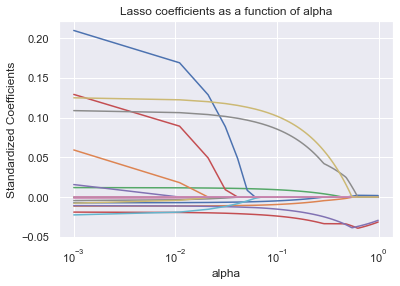

In [224]:
import numpy as np
import matplotlib.pyplot as plt

alphas = arange(0.001, 1, 0.01)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, Y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [225]:
cross_validation = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

lasso_model = LassoCV(alphas=arange(0.001, 1, 0.01), cv=cross_validation , n_jobs=-1)

lasso_model .fit(X, y)

print('alpha: %f' % lasso_model .alpha_)
pred_train_lasso= lasso_model .predict(X_train)
pred_test_lasso= lasso_model .predict(X_test)

print("MSE LASSO train: ", np.sqrt(mean_squared_error(Y_train,pred_train_lasso)))
print("R2 train: ", r2_score(Y_train, pred_train_lasso))

print("MSE LASSO test: ", np.sqrt(mean_squared_error(Y_test,pred_test_lasso)))
print("R2 test: ", r2_score(Y_test, pred_test_lasso))

alpha: 0.001000
MSE LASSO train:  0.6378789238185943
R2 train:  0.6559151293792789
MSE LASSO test:  0.6395606784662297
R2 test:  0.6545895354476856


In [226]:
lasso_best = LassoCV(alphas=arange(0.001, 1, 0.01), n_jobs=-1)

lasso_best.fit(X, y)
print('R squared training set', round(lasso_best.score(X_train, Y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, Y_test)*100, 2))

R squared training set 65.59
R squared test set 65.46


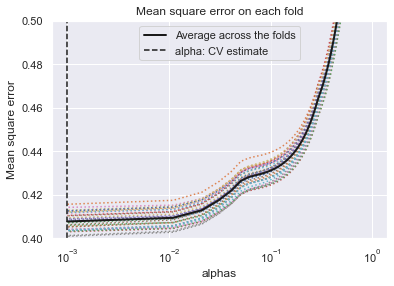

In [227]:
plt.semilogx(lasso_model.alphas_, lasso_model.mse_path_, ":")
plt.plot(
    lasso_model.alphas_ ,
    
    lasso_model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso_model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0.4, 0.5
plt.ylim(ymin, ymax);

Eliminem aquestes columnes per poder buscar quina es la millor regressió:


In [228]:
#Aquesta copia del Dataset serà usada més endavant quan treballem amb la classificació
df2 = df.copy()

In [229]:
df.drop(columns=droped, inplace = True)

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236349 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MWG      236349 non-null  int64  
 1   NWG      236349 non-null  int64  
 2   KWG      236349 non-null  int64  
 3   MDIMC    236349 non-null  int64  
 4   NDIMC    236349 non-null  int64  
 5   MDIMA    236349 non-null  int64  
 6   NDIMB    236349 non-null  int64  
 7   KWI      236349 non-null  int64  
 8   VWM      236349 non-null  int64  
 9   VWN      236349 non-null  int64  
 10  Target   236349 non-null  float64
 11  SA_0     236349 non-null  uint8  
 12  SB_0     236349 non-null  uint8  
 13  STRM_0   236349 non-null  uint8  
 14  STRN_0   236349 non-null  uint8  
 15  prework  236349 non-null  int64  
 16  MWI      236349 non-null  float64
 17  NWI      236349 non-null  float64
dtypes: float64(3), int64(11), uint8(4)
memory usage: 27.9 MB


### Dades amb les que treballarem

Preparem les dades amb les que treballarem a les regressions

In [231]:
X = df.drop(columns=['Target'])
y = df['Target'].values

Min_Max = MinMaxScaler()
y = y.reshape(-1,1)
X = Min_Max.fit_transform(X)

Realitzem la separació en Train i Test

In [232]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.30)

### Regression with Lasso best features

L'objectiu de la següent cel·la es avaluar diferents regressors per trobar quin es el que s'ajusta millor al model donant-nos el millor valor del $R^2$, és a dir l'usarem com a mètrica principal per avaluar el nostre model. Altrement, al ser una regressió les mètriques que també tindrem en compte són:
- $R^2$: El coeficient de $R^2$ score, ens diu com de representatiu serpa la predicció feta pel model, comparada amb les dades reals. Normalment el coeficient té un valor entre $0$ i $1$, on $0$ seria el pitjor resultat i $1$ una representació perfecte de les dades.

- $MSE$: Correspon a calcular la mitjana de tots els errors al quadrat. Error aquí significa la diferència entre el valor previst i el valor correcte. Aquesta mètrica és una de les més antigues i utilitzades. Malgrat això, és una anàlisi molt senzilla i es veu afectada pels canvis de magnitud en les característiques.

- $RMSE$: és l'arrel quadrada de l'MSE. Aquesta mètrica té les mateixes propietats que l'anterior, excepte que aquesta sí que ens dóna la informació de manera absoluta.

In [113]:
#funció usada més endavant
def learning_curves(pipeline, X,y):
    train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X, y=y,
                                                           cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                         n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='orange', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='orange')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

Provem diversos models de regressió aplicant un `Cross-Validation`i avaluem el resultat:

#### Models escollits:

- **`Regressió Lineal`**: Considera que donat un conjunt d'observacions la mitja de la variable resposta $y$ es relaciona de forma lineal amb les variables regressores, donada l'equació: 

$$\mu_y = \beta_0 + \beta_1x_1+...+\beta_px_p$$


- **`Elastic Net`**: `Elastic Net` inclou una regularització que combina la penalització `L1` i `L2`. El grau en el qual influeix cadascuna de les penalitzacions està controlat per l'hiperparàmetre $\alpha$. El seu valor va del 0 a l'1, si val 0 s'aplica un `Ridge` si val 1 s'aplica un `Lasso`. La combinació de les dues penalitzacions acostuma a donar bons resultats.


- **`KNN Regressor`**: `KNN` és un algorisme senzill que emmagatzema tots els casos disponibles i prediu l'objectiu numèric a partir d'una mesura de similitud. La implementació senzilla de la regressió `KNN` és calcular la mitjana amb finalitat numèrica dels K veïns més propers. Un altre enfocament utilitza una mitjana ponderada de distància inversa dels K veïns més propers.


- **`SGD Regressor`**: EL `SGD Regressor` fa servir el descens del gradient per adaptar-se.


- **`RF Regressor`**: L'algorisme del `Random Forest Regressor` combina mètodes d'aprenentatge conjunt amb arbres de decició per crear múltiples arbres de decisió dibuixats aleatòriament a partir de les dades, fent la mitjana dels resultats per produir un nou resultat que sovint condueix a prediccions/classificacions fortes.

In [233]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledSGD', Pipeline([('Scaler', MinMaxScaler()),('SGD', SGDRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MinMaxScaler()),('RF', RandomForestRegressor())])))

In [234]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, shuffle = False)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: r^2: %f std: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: r^2: 0.655338 std: 0.003627
ScaledEN: r^2: -0.000035 std: 0.000046
ScaledKNN: r^2: 0.919111 std: 0.002078
ScaledSGD: r^2: 0.654872 std: 0.003626
ScaledRF: r^2: 0.999154 std: 0.000022


Com veiem de l'execució les millors regressions segons el $R^2$ score són el `KNNregressor`, el `RandomForestRegressor` i el `SGDRegressor`. Estudiarem individualment cada cas per veure el seu comportament segons un `GridSearch` juntament amb un `Cross-Validation` i ens quedarem amb el millor model. 


In [235]:
#Llistes per guardar els resultats i comparar posteriorment
cv_result = []
mean_squared_errors = []
r_mean_squared_errors = []
timex = []

### KNNRegressor

Mirem quina es la millor `k` pel nostre model, és a dir la que ens dona el valor de $R^2$ més alt, i mirem si millora respecte el pipline

##### Optimització d'hiperparàmetres

In [236]:
from sklearn import neighbors
from sklearn.metrics import r2_score

rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, Y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
    r2 = r2_score(Y_test, pred)
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error, "r^2:", r2)

RMSE value for k=  1 is: 0.28034424058282925 r^2: 0.9337384667148461
RMSE value for k=  2 is: 0.27014569350727485 r^2: 0.9384717869901211
RMSE value for k=  3 is: 0.27771789731446794 r^2: 0.9349741644527599
RMSE value for k=  4 is: 0.2847007107905413 r^2: 0.9316630947211763
RMSE value for k=  5 is: 0.29421542507050347 r^2: 0.9270191225305413
RMSE value for k=  6 is: 0.30606824232974816 r^2: 0.9210204338933735
RMSE value for k=  7 is: 0.3183549145631749 r^2: 0.914552114177582
RMSE value for k=  8 is: 0.32990997108040154 r^2: 0.9082366863490915
RMSE value for k=  9 is: 0.3413183535519091 r^2: 0.901780552110323
RMSE value for k=  10 is: 0.35170582890143676 r^2: 0.895711280129357


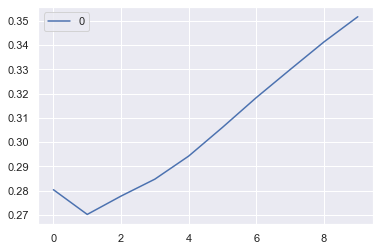

In [237]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

Obtenim que la millor `K`, pel `KNN regressor` és 1, per tant, entrenem el model passant el paràmetre de `K` trobat i mostrem les diverses gràfiques per corroborar els resultats. 

In [239]:
st = time.time()

model = KNeighborsRegressor(n_neighbors = 1)
model.fit(X_train, Y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set

end = time.time()

error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
r2 = r2_score(Y_test, pred)

mean_squared_errors.append(mean_squared_error(Y_test,pred)) 
r_mean_squared_errors.append(sqrt(mean_squared_error(Y_test,pred)))
cv_result.append(r2)
timex.append(end-st)

print("El millor model amb KNN regressor es amb K = 1, mse:", {error}, " i r2:", {r2})

El millor model amb KNN regressor es amb K = 1, mse: {0.28034424058282925}  i r2: {0.9337384667148461}


Per mirar els resultats mirem la gràfica entre els punts de Y_test i els predits:

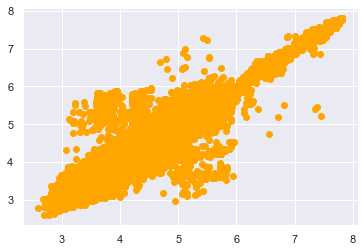

In [240]:
plt.scatter(Y_test, pred, color='orange')

Com podem veure els resultats són una mica confusos, ja que obtenim un $R^2$ de 0.9337 i la línia que prediu, la part inferior dels punts és bastant dispersa. Mirem que són aquells punts, eliminant els que coincideixen amb certa tolerància dels punts reals. Ja que segurament s'està cometent overfitting.

In [241]:
#punts fora la línia:
llistap = []
llistat = []

#Punts dins la línia:
b1 = []
b2 = []
for i in range(len(pred)):
    if(abs(pred[i]-Y_test[i]) > 0.1):
      llistap.append(pred[i])
      llistat.append(Y_test[i])
    else:
      b1.append(pred[i])
      b2.append(Y_test[i])

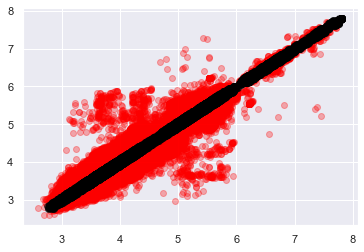

In [242]:
plt.scatter(llistat, llistap, color='red', alpha = 0.3)
plt.scatter(b1, b2, color ='black', alpha=0.5)
plt.show()

In [243]:
print("Longitud punts allunyats de la línia central:", len(llistap))
print("Longitud punts cercans a la línia central amb tol 0.1:", len(b1))

Longitud punts allunyats de la línia central: 38828
Longitud punts cercans a la línia central amb tol 0.1: 32077


In [244]:
r2_score(b1, b2)

0.9983908034587615

In [245]:
r2_score(llistat, llistap)

0.7770079580921813

Com podem veure tenim 38828 punts situats fora la linia central, la que vindria a ser la millor predicció, i 32077 amb punts situats sobre la linia central i que coincideixen amb una tolèrancia del 0.1 amb els valors reals. Per tant podriem considerar que s'esta cometen algun error de Overfitting, per comprovar-ho mirem les corbes d'aprenentatge del KNN per veure com es comporta amb el train i el test.

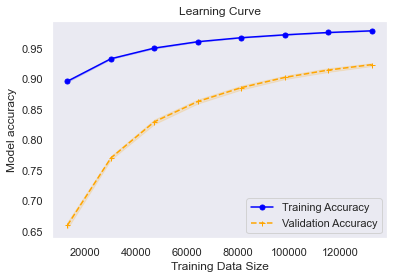

In [246]:
#No usem la funció ja que tarda aproximadament 6h a realitzar tots els càlculs, s'ha intentat reduir tot i perdre precisió per poder executar més ràpid el programa
pipeline = make_pipeline(KNeighborsRegressor(n_neighbors = 2))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=Y_train,
                                                        cv=5, train_sizes=np.linspace(0.1, 1.0, 8),
                                                      n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='orange', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='orange')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Com podem veure es comet un overfitting, per tant descartem el model del `KNN regressor`

 ### SGD Regressor

Evaluarem el `SGD Regressor` en funció del pàrametre $\alpha$, és a dir el coeficient d'aprenentatge en regressió.

MSE with alpha=0.0001: 0.4087016415331902  /  N iterations to converge: 9, r^2:0.6554243480310876
MSE with alpha=0.001: 0.41003310699112155  /  N iterations to converge: 9, r^2:0.6543017917905019
MSE with alpha=0.01: 0.4329806393869713  /  N iterations to converge: 8, r^2:0.6349547666434654
MSE with alpha=0.05: 0.49272484163055535  /  N iterations to converge: 7, r^2:0.5845845323517254
MSE with alpha=0.1: 0.5496746833188876  /  N iterations to converge: 7, r^2:0.5365702186443756
MSE with alpha=0.2: 0.6424421033884297  /  N iterations to converge: 7, r^2:0.4583581661260092
MSE with alpha=0.3: 0.7105638281380627  /  N iterations to converge: 7, r^2:0.4009248569990984
MSE with alpha=0.4: 0.7650452032540335  /  N iterations to converge: 7, r^2:0.3549917032189369
MSE with alpha=0.5: 0.8162686500131053  /  N iterations to converge: 7, r^2:0.3118053032404853
MSE with alpha=0.6: 0.8397845504635499  /  N iterations to converge: 7, r^2:0.2919790879628793
MSE with alpha=0.7: 0.886815015563054  / 

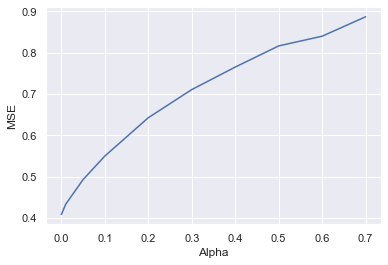

In [247]:
list_alpha = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
list_MSE = []

for i in list_alpha:
    regr = SGDRegressor(alpha = i)
    regr.fit(X_train, Y_train)
    Y_pred = regr.predict(X_test)
    MSE = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    list_MSE.append(MSE)
    print(f'MSE with alpha={i}: {MSE}  /  N iterations to converge: {regr.n_iter_}, r^2:{r2}')

plt.plot(list_alpha,list_MSE)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

In [248]:
st = time.time()

regr = SGDRegressor(alpha = 0.0001, penalty='l1')
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)

end = time.time()

In [249]:
MSE = mean_squared_error(Y_test, Y_pred)
params = regr.get_params()
r2train = regr.score(X_train, Y_train)
r2test = regr.score(X_test, Y_test)

mean_squared_errors.append(MSE) 
r_mean_squared_errors.append(sqrt(mean_squared_error(Y_test,Y_pred)))
cv_result.append(r2test)
timex.append(end-st)

Per mirar els resultats mirem la gràfica entre els punts de Y_test i els predits:

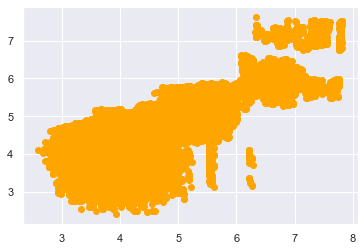

In [250]:
plt.scatter(Y_test, Y_pred, color='orange')

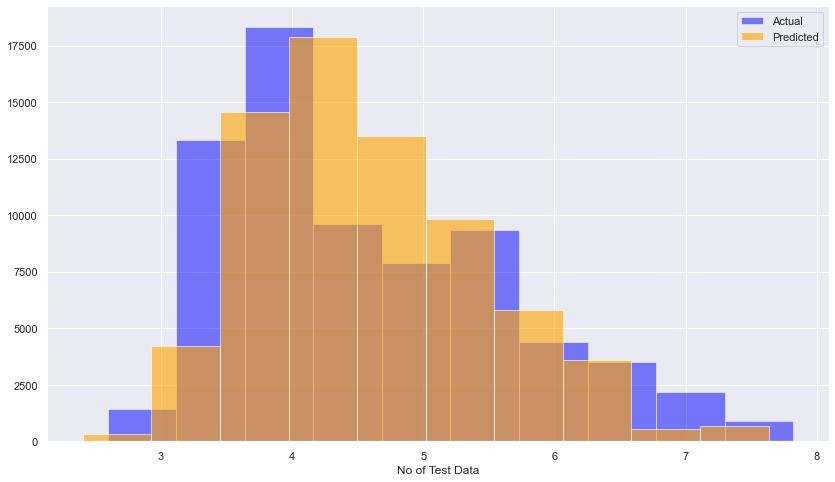

In [251]:
plt.figure(figsize=(14,8))
plt.hist(np.array(Y_test), color = 'blue', alpha = 0.5)
plt.hist(Y_pred, color='orange', alpha = 0.6)

plt.legend(["Actual","Predicted"])
plt.xlabel('No of Test Data')
plt.show()

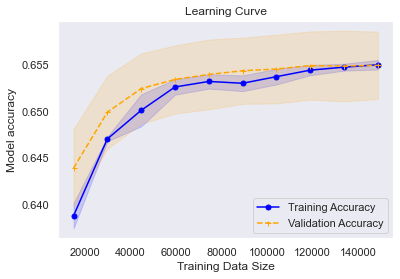

In [252]:
pipeline = make_pipeline(SGDRegressor(alpha = 0.0001, penalty='l1'))
learning_curves(pipeline, X_train,Y_train)

### RandomForestRegressor

Aquest és un model `ensemble`, per tant els resultats haurien de millorar respecte els altres dos.

En aquest cas, no ha fet falta fer un GridSearch ja que avaluat amb els pàrametres estàndars el model ja ens dona resultats molt bons. També s'ha evitat fer-lo a causa del temps que trigava en completar-lo totalment i extreure els millors valors.

In [253]:
st = time.time()

regr = RandomForestRegressor(criterion = 'squared_error', max_features= 1.0, n_estimators =100)
regr.fit(X_train, np.ravel(Y_train,order='C'))
pred=regr.predict(X_test) #make prediction on test set

end = time.time()

error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
r2 = r2_score(Y_test, pred)

In [254]:
mean_squared_errors.append(mean_squared_error(Y_test,pred)) 
r_mean_squared_errors.append(error)
cv_result.append(r2)
timex.append(end-st)

Per mirar els resultats mirem la gràfica entre els punts de Y_test i els predits:

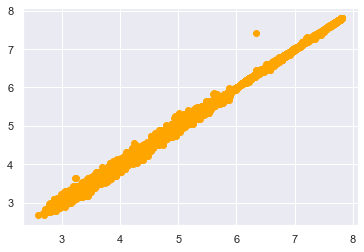

In [255]:
plt.scatter(Y_test, pred, color='orange')

In [256]:
importance = regr.feature_importances_

In [257]:
X1 = df.drop(columns=['Target'])
feature_names = list(X1.columns)

Mirem la importància de cada feature:

In [258]:
tree_imp = pd.DataFrame(columns = ['Variable','Importance'])
tree_imp.Variable = feature_names
tree_imp.Importance = importance
tree_imp

,Variable,Importance
0,MWG,0.008939
1,NWG,0.005536
2,KWG,0.012179
3,MDIMC,0.009027
4,NDIMC,0.006874
5,MDIMA,0.001382
6,NDIMB,0.001334
7,KWI,0.004120
8,VWM,0.013277
9,VWN,0.007002


A causa del bon resultat mirem el $R^2$ tant per test com per train, i comprovem que no estiguem provocant un overfitting

In [259]:
print('R squared training set', round(regr.score(X_train, Y_train)*100, 6))
print('R squared test set', round(regr.score(X_test, Y_test)*100, 6))

R squared training set 99.989522
R squared test set 99.926123


Com podem veure la diferència entre els dos es mínima, per tant podriem considerar que no s'esta produint un `Overfitting`.

Per veure com evoluciona el `Random Forest Regression`, mostrem la `Learning Curve` d'aquesta manera podrem avaluar si la partició escollida de dades és la correcte, o podem millorar el resultat, i ens acabarem d'assegurar que no estiguem produïnt un `Overfitting`.

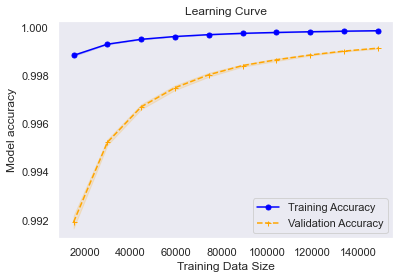

In [260]:
pipeline = make_pipeline(RandomForestRegressor(criterion = 'squared_error', max_features= 1.0, n_estimators =100))
learning_curves(pipeline, X_train,Y_train)

#### Taula de resultats

Per comparar els resultats dels tres models escollits per mirar en més detall, he realitzat dues taules. A la primera podrem veure la comparació entre $R^2$, el $MSE$ i el $RMSE$, dels models. A la segona trobarem la comparació de temps d'execució.

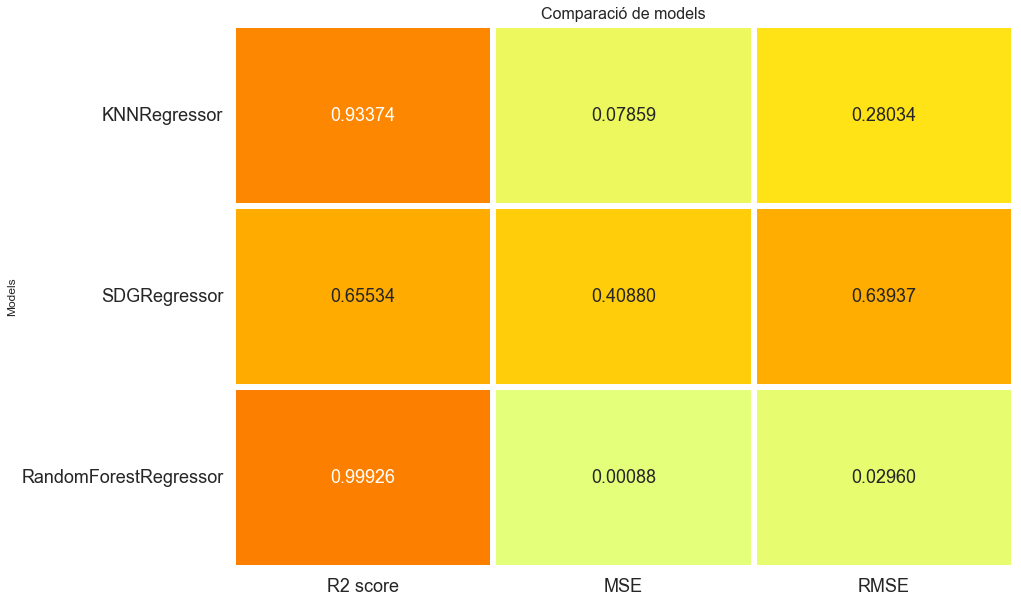

In [261]:
sns.set_style("darkgrid")
cv_results = pd.DataFrame({"R2 score":cv_result,
                           "MSE":mean_squared_errors,
                           "RMSE": r_mean_squared_errors,
                           
                           "Models":["KNNRegressor", 
                                     "SDGRegressor",
                                     "RandomForestRegressor",
                                     ]})

cv_results.index = cv_results["Models"]

cv_results  = cv_results.drop(["Models"], axis = 1)

f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(cv_results, annot=True,cmap = "Wistia",fmt= '.5f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18})

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Comparació de models", size = 16)
plt.show()

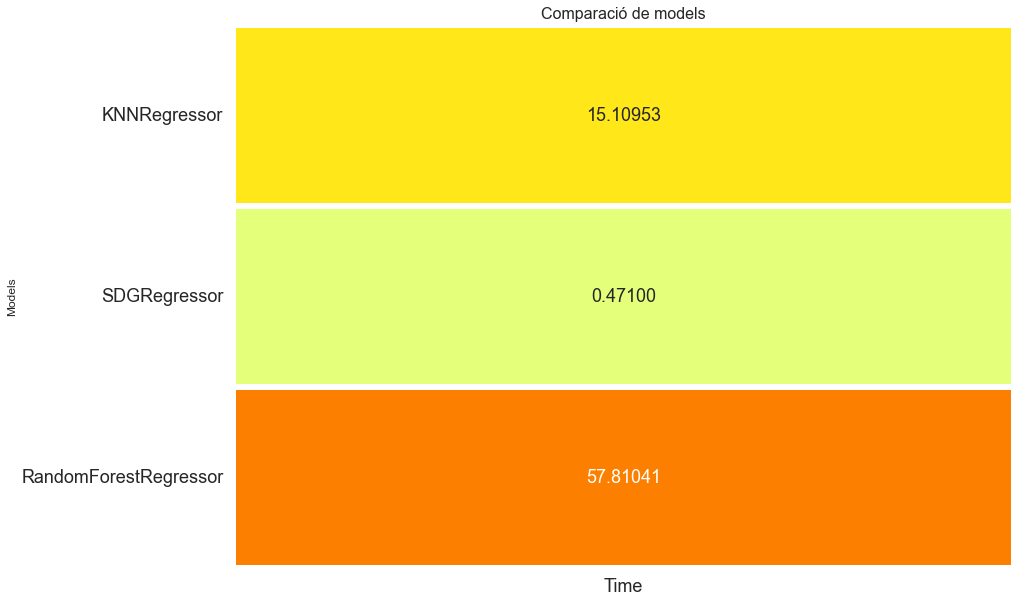

In [262]:
sns.set_style("darkgrid")
cv_results = pd.DataFrame({"Time": timex,
                           "Models":["KNNRegressor", 
                                     "SDGRegressor",
                                     "RandomForestRegressor",
                                     ]})

cv_results.index = cv_results["Models"]

cv_results  = cv_results.drop(["Models"], axis = 1)

f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(cv_results, annot=True,cmap = "Wistia",fmt= '.5f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18})

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Comparació de models", size = 16)
plt.show()

Com podem veure, el model amb millors resultats és el `RandomForest Regression`, del qual obtenim un $R^2$ casi perfecte. Per tant, tot i que el model pugui ser més lent que algun altre, podem sacrificar temps per resultats.
Per tant el considerem com el millor model per predir les nostres dades.

# Classificació

El meu Dataset no està pensat per realitzar una classificació, però amb diverses modificacions podem crear una nova variable binària, on $0$ serà que el temps mitjà d'execució queda per sota la mitjana i $1$ que queda per sobre.

Recuperem la còpia realitzada al dataset abans d'eliminar les variables seleccionades per la Lasso. És a dir a la classificació treballarem amb totes les variables predictores possibles.

In [263]:
mean = df2['Target'].mean()
df2.loc[df2['Target'] <= mean, 'Target'] = 0
df2.loc[df2['Target'] > mean, 'Target'] = 1
df2['Target'] = df2['Target'].astype('int')

df_target=df2[['Target']].values
df_features=df2.drop(columns=['Target'],axis=1).values
x1_train, x1_test, y1_train, y1_test = train_test_split(df_features, df_target, test_size = 0.3, random_state = 0)

Mirem com ens queda la distribució de la variable `Target` i veiem que els temps d'execució per sota o igual a la mitjana predominen.

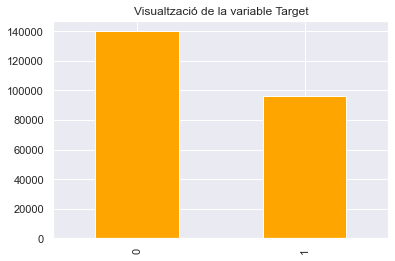

In [264]:
plot = df2['Target'].value_counts().plot(kind='bar', title='Visualtzació de la variable Target', color ="orange")

In [265]:
sc = StandardScaler()
x1_train = sc.fit_transform(x1_train)
x1_test = sc.transform(x1_test)

In [266]:
Targeted_feature = df2["Target"]
all_features = df2.drop("Target",axis=1)

Funció que usarem per la classificació:

In [267]:
def plot_features(importance, Features):
    #Features<-df.columns
    coef_dict = {}
    for coef, feat in zip(importance,Features):
        coef_dict[feat] = coef  
        
    cycol = cycle(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink',
                  'tab:gray','tab:olive','tab:cyan'])
    colors=[]
    for i in range(0,len(Features)):
        colors.append(next(cycol))

    plt.figure(figsize=(25,15))
    plt.bar(coef_dict.keys(),coef_dict.values(),color=colors) 

In [268]:
cv_result =  []
mean_squared_errors = []
roc_auc_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
timec= []

Avaluem diferents models per mirar quin ens dona els millors resultats, les mètriques que usarem per evaluar els diferents models són, l'`accuracy` la corba `ROC` , la matriu de confusió i la `f1 score`.

- **Corba `ROC`**: La corba `ROC` mostra el compromís entre la sensibilitat (o `TPR`) i l'especificitat (1 - `FPR`). Ens dona la relació entre els veritables positius i els falsos positius de la nostra classificació. Els classificadors que donen corbes més properes a la cantonada superior esquerra indiquen un millor rendiment, com més proper el valor de l'àrea a 1 millor serà la nostra classificació, si és menor o igual a 0.5 vol dir que la nostra classificació és pitjor que llençar una moneda a l'aire. 


- **Matriu de confusió** : aquí podrem visualitzar diferents mètriques com: `Recall`, `Specifity` o `Precision`. A més a més ens dira quins son els valors estimats de manera correcte pel model, i en quins casos s'ha equivocat


- **`f1 score`**: Combina les mesures de `Precision` i `Recall`en un sol valor. Per tant, tenim que és una relació entre els veritables positius, els falsos positius i els falsos negatius. 
 $$F_1=2\frac{Prec\cdot Rec}{Prec+Rec}=\frac{2TP}{2TP+FP+FN}$$


- **`Accuracy`**: És la ràtio d'elements encertats a l'hora de realitzar la classificació. És a dir les prediccions iguals als valors reals dividits entre el nombre total de prediccions.  
$$Acc=\frac{TP+TN}{TP+FP+TN+FN}$$

Els models que seran usats són:
- **`Gradient Boosting`**: Un model Gradient Boosting està format per un conjunt d'arbres de decisió individuals, entrenats de forma seqüencial, de forma que cada nou arbre intenta millorar els errors de l'arbre anterior. La predicció d'una nova observació s'obté afegint a les prediccions de tots els arbres individuals que formen el model.


- **`Regressió Logística`**: El mètode de regressió logística és un mètode estadístic que s'usa per a resoldre problemes de classificació binària, on el resultat només pot ser de naturalesa dicotòmica, és a dir, només pot prendre dos valors possibles.


- **`XGBoost`**: És un mètode d'aprenentatge automàtic supervisat per la classificació i regressió. XGBoost es l'abreviatura de les paraules "Extreme Gradient Boosting". Aquest mètode es basa en arbres de decisió i suposa una millora sobre altres mètodes, com el bosc aleatori i reforç de gradients. Funciona bé amb datasets grans i complexos en utilitzar diversos mètodes d'optimització.

### Gradient Boosting

Primerament fem un primer entrenament sense GridSearch ni Crossvalidation, ja que és més ràpid i ens permetrà avaluar com de bo podria ser el model

In [291]:
end1 = time.time()
gbc1 = GradientBoostingClassifier()
gbc1.fit(x1_train,y1_train)
prediction_rm=gbc1.predict(x1_test)
start1 = time.time()

In [292]:
print('Accuracy without Grid and crossvalidation: ',round(sk.accuracy_score(prediction_rm,y1_test)*100,2))

Accuracy without Grid and crossvalidation:  96.74


Com podem veure l'accuracy obtinguda és molt elevada, apliquem un GridSearch i un Crossvalidation per mirar si milloren els resultats.

In [201]:
gbc_param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "min_samples_split": [2,3,10],
    "min_samples_leaf": [1,3,10]
    }
gbc = GradientBoostingClassifier()
gbc = GridSearchCV(gbc, gbc_param_grid, cv = StratifiedKFold(n_splits = 5),
                       scoring = "accuracy",
                       n_jobs = -1,verbose = 2 )

In [202]:
start = time.time()

gbc.fit(x1_train,y1_train)
prediction_rm=gbc.predict(x1_test)
result_rm=gbc.best_score_
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))

end = time.time()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
The cross validated score for Random Forest Classifier is: 96.92


In [293]:
print(gbc.best_estimator_)

GradientBoostingClassifier(learning_rate=0.2)


In [311]:
print("Temps d'execució Grid: ", end-start)

Temps d'execució Grid:  1885.21


In [295]:
timec.append(end1-start1)

Text(0.5, 1.05, 'Confusion_matrix')

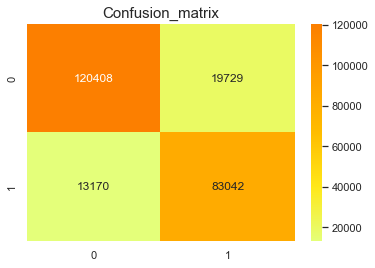

In [296]:
y_pred = cross_val_predict(gbc1,all_features,Targeted_feature,cv=10)
sns.heatmap(sk.confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="Wistia")
plt.title('Confusion_matrix', y=1.05, size=15)

ROC score is:  0.9946335009206173
f1 score is: 0.9671978527819532


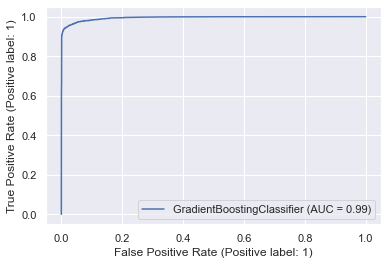

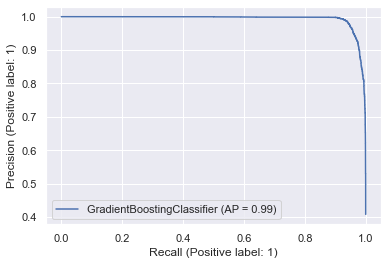

In [297]:
y_pred_proba = gbc1.predict_proba(x1_test)
print("ROC score is: ", sk.roc_auc_score(y1_test, y_pred_proba[:,1]))
sk.RocCurveDisplay.from_estimator(gbc1,x1_test,y1_test)
sk.PrecisionRecallDisplay.from_estimator(gbc1,x1_test,y1_test)
f1 = sk.f1_score(y1_test, gbc1.predict(x1_test), average='weighted')
print("f1 score is:", f1)

<BarContainer object of 19 artists>

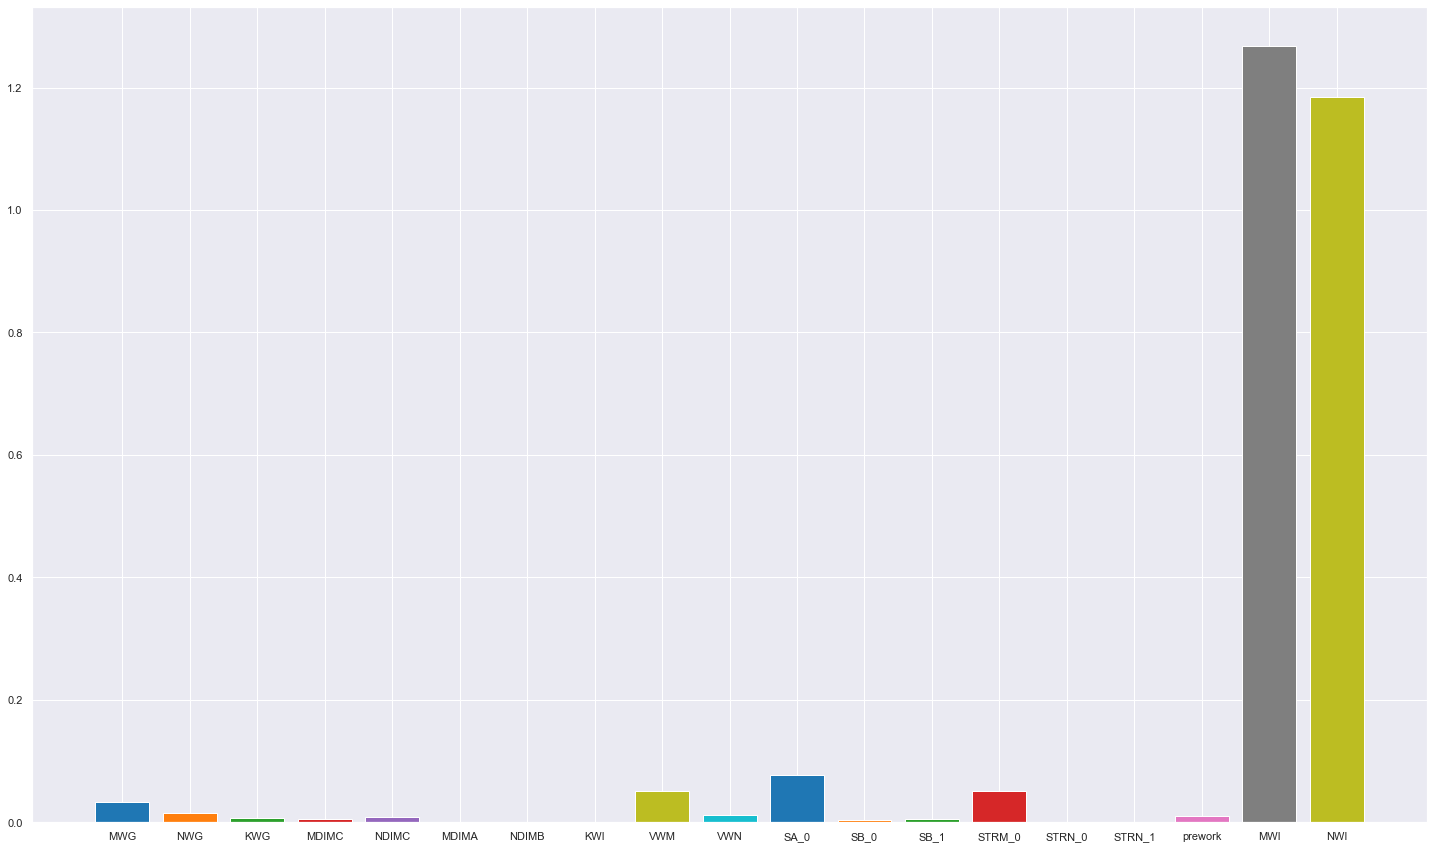

In [298]:
#Pot ser que cada classificador agafi la importancia diferent
from sklearn.inspection import permutation_importance
results = permutation_importance(gbc1, x1_train, y1_train, scoring='r2')
importance = results.importances_mean
    
coef_dict = {}
for coef, feat in zip(importance,all_features):
    coef_dict[feat] = coef  

cycol = cycle(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink',
              'tab:gray','tab:olive','tab:cyan'])
colors=[]
for i in range(0,len(all_features)):
    colors.append(next(cycol))

plt.figure(figsize=(25,15))
plt.bar(coef_dict.keys(),coef_dict.values(),color=colors) 

In [299]:
cv_result.append(round(result_rm.mean(),2))
mean_squared_errors.append( sk.mean_squared_error(y1_test,gbc1.predict(x1_test)))
roc_auc_scores.append(sk.roc_auc_score(y1_test, y_pred_proba[:,1]))
recall_scores.append(sk.recall_score(y1_test, gbc1.predict(x1_test), average='weighted'))
precision_scores.append(sk.precision_score(y1_test, gbc1.predict(x1_test), average='weighted'))
f1_scores.append(f1)

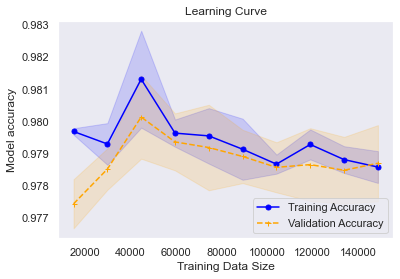

In [300]:
pipeline = make_pipeline(StandardScaler(),
                        GradientBoostingClassifier(learning_rate=0.2))
learning_curves(pipeline, x1_train, y1_train)

#### Resultats
Com podem veure ja de primeres el model ens treu una accuracy molt elevada, i a l'aplicar el `GridSearch` i `Crossvalidation` augmenta més encara. La corba `ROC` és pràcticament 1, per tant, obtenim uns resultats molt bons, ja que com hem dit anteriorment, busquem que el valor sigui el més proper a 1 possible. La matriu de confusió ens indica que tenim pocs falsos positius i falsos negatius respecte a els valors correctes.

### Regressió Logística

In [269]:
model = LogisticRegression()
model.fit(x1_train,y1_train)
prediction_rm=model.predict(x1_test)

print('Accuracy without Grid and crossvalidation: ',round(sk.accuracy_score(prediction_rm,y1_test)*100,2))

Accuracy without Grid and crossvalidation:  89.95


Apliquem un GridSearch juntament amb Crossvalidation per mirar si milloren els resultats:

In [270]:
log_param_grid = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

start = time.time()

LogReg = LogisticRegression()
LogReg = GridSearchCV(LogReg, log_param_grid, cv = StratifiedKFold(n_splits = 5),
                       scoring = "accuracy",
                       n_jobs = -1,verbose = 2 )
LogReg.fit(x1_train,y1_train)

end = time.time()

prediction_rm=LogReg.predict(x1_test)
print(pd.concat([pd.DataFrame(LogReg.cv_results_["params"]),pd.DataFrame(LogReg.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1))
result_rm=LogReg.best_score_
print('The cross validated score for Logistic Regression is:',round(result_rm.mean()*100,2))
print('Temps execució:', end-start)
timec.append(end-start)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
      solver  Accuracy
0  newton-cg  0.900528
1      lbfgs  0.900528
2  liblinear  0.900528
3        sag  0.900534
4       saga  0.900534
The cross validated score for Logistic Regression is: 90.05
Temps execució: 20.8232319355011


Text(0.5, 1.05, 'Confusion_matrix')

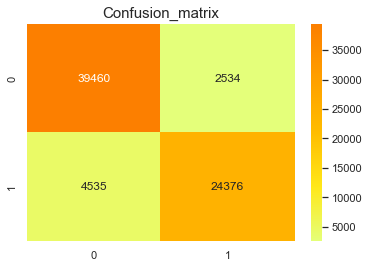

In [271]:
y_pred = cross_val_predict(model,x1_test,y1_test,cv=10)
sns.heatmap(sk.confusion_matrix(y1_test,y_pred),annot=True,fmt='3.0f',cmap="Wistia")
plt.title('Confusion_matrix', y=1.05, size=15)

ROC score is:  0.9268335022427614
f1 score is: 0.8988233425615848


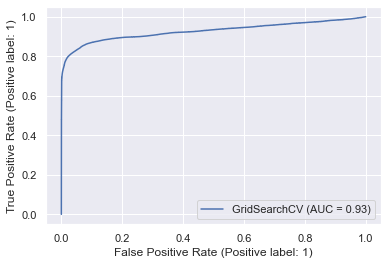

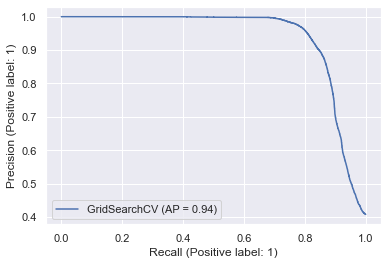

In [272]:
y_pred_proba = LogReg.predict_proba(x1_test)
print("ROC score is: ", sk.roc_auc_score(y1_test, y_pred_proba[:,1]))

sk.RocCurveDisplay.from_estimator(LogReg,x1_test,y1_test)
sk.PrecisionRecallDisplay.from_estimator(LogReg,x1_test,y1_test)

f1 = sk.f1_score(y1_test, LogReg.predict(x1_test), average='weighted')
print("f1 score is:", f1)

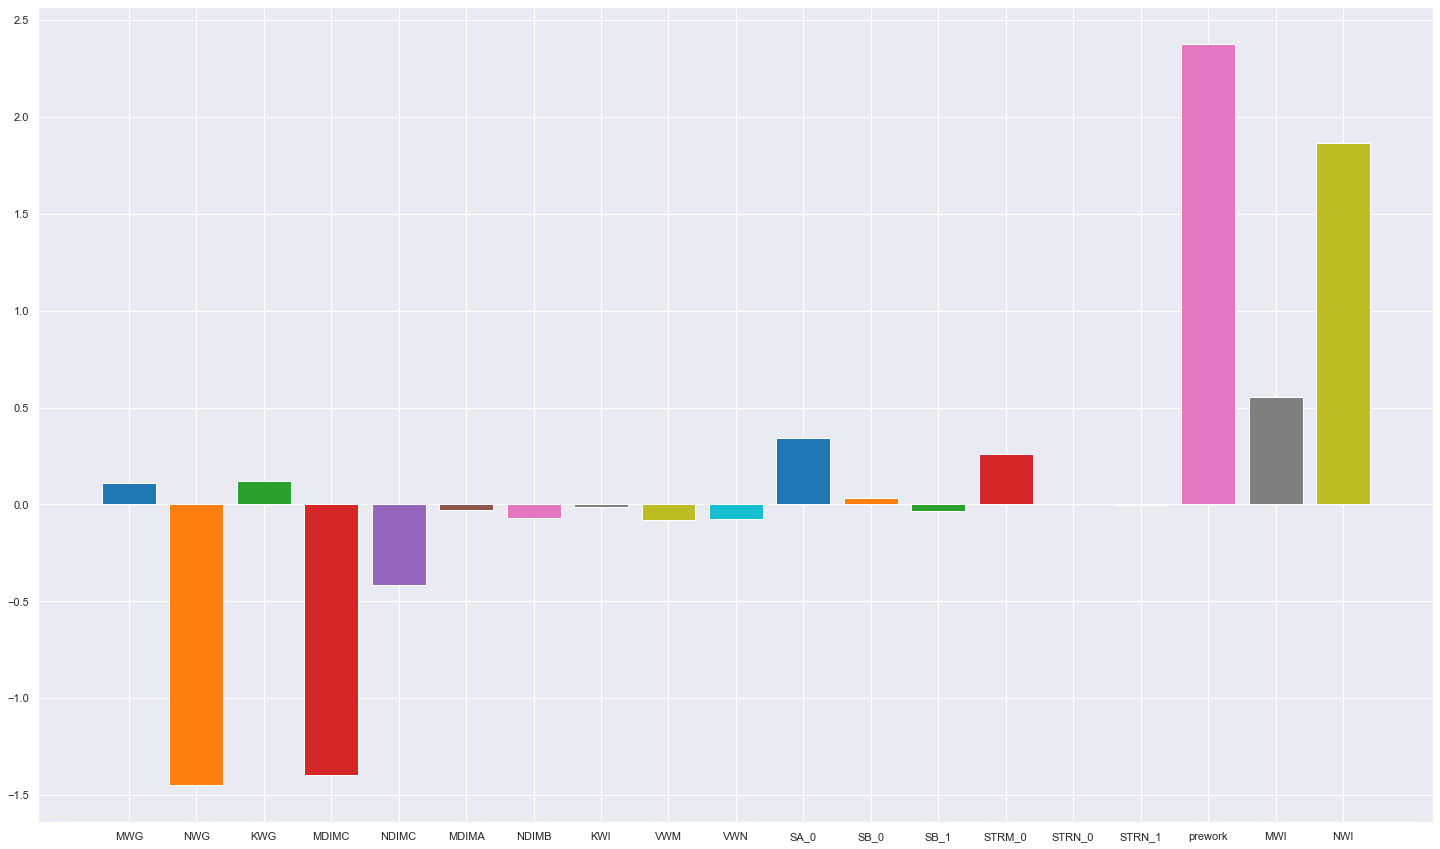

In [273]:
plot_features(model.coef_[0],df2.columns.drop("Target"))

In [274]:
cv_result.append(round(result_rm.mean(),2))
mean_squared_errors.append( sk.mean_squared_error(y1_test,model.predict(x1_test)))
roc_auc_scores.append(sk.roc_auc_score(y1_test, y_pred_proba[:,1]))
recall_scores.append(sk.recall_score(y1_test, model.predict(x1_test), average='weighted'))
precision_scores.append(sk.precision_score(y1_test, model.predict(x1_test), average='weighted'))
f1_scores.append(f1)

#### Resultats
Podem veure com la corba 'ROC', s'aproxima bastant bé, ja que la corba s'ajusta a la cantonada esquerra. La matriu de confusió també ens indica bons resultats, ja que els falsos negatius i falsos positius són mínims comparats amb els resultats de la diagonal principal.
Finalment, l'accuracy obtinguda ens permet dir que la Regressió Logística és un bon model per les nostres dades.

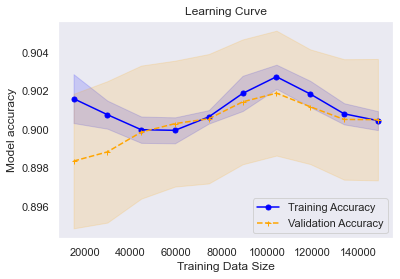

In [275]:
pipeline = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='saga', random_state=1, max_iter=10000))
learning_curves(pipeline, x1_train, y1_train)

Veiem la corba d'aprenentatge amb els paràmetres que millors resultats han donat, on podem veure que aproximadament, quan la mostra d'entrenament és de 100000 obtenim els millors resultats, tant de validació com d'entrenament.

### XGBoost

Primerament fem un primer entrenament sense GridSearch ni Crossvalidation, ja que és més ràpid i ens permetrà avaluar com de bo podria ser el model

In [276]:
from xgboost import XGBClassifier

In [277]:
start = time.time()
xgb = XGBClassifier()
xgb.fit(x1_train, y1_train)
end = time.time()

In [278]:
print("Temps d'entrenament:", end-start)
timec.append(end-start)

Temps d'entrenament: 4.292261838912964


In [279]:
y_pred = xgb.predict(x1_test)
predictions = [round(value) for value in y_pred]

In [280]:
# evaluate predictions
accuracy = sk.accuracy_score(y1_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.75%


L'accuracy obtinguda ja es altissima per tant no necessitem realitzar una cerca de hiperparàmetres per obtenir millors resultats. Mostrem la corba `ROC` i les mètriques a avaluar:

Text(0.5, 1.05, 'Confusion_matrix')

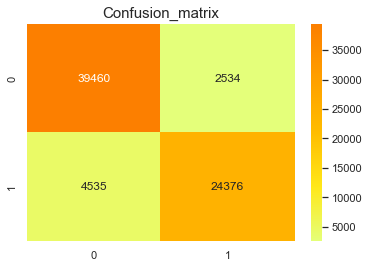

In [281]:
y_pred = cross_val_predict(model,x1_test,y1_test,cv=10)
sns.heatmap(sk.confusion_matrix(y1_test,y_pred),annot=True,fmt='3.0f',cmap="Wistia")
plt.title('Confusion_matrix', y=1.05, size=15)

ROC score is:  0.9999613949076304
f1 score is: 0.9975313936893985


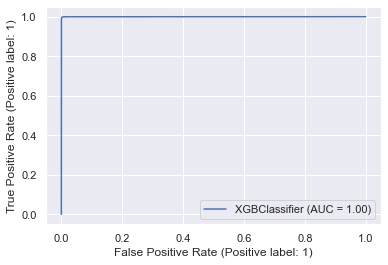

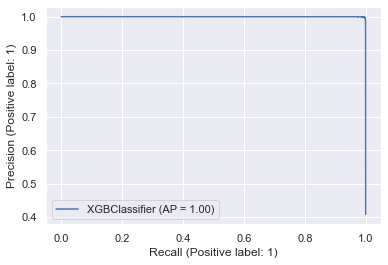

In [282]:
y_pred_proba = xgb.predict_proba(x1_test)
print("ROC score is: ", sk.roc_auc_score(y1_test, y_pred_proba[:,1]))

sk.RocCurveDisplay.from_estimator(xgb,x1_test,y1_test)
sk.PrecisionRecallDisplay.from_estimator(xgb,x1_test,y1_test)

f1 = sk.f1_score(y1_test, xgb.predict(x1_test), average='weighted')
print("f1 score is:", f1)

Com podem veure els resultats són gairebé impacables, a la matriu de confusió el nombre de falsos positius i falsos negatius és mínim, i a les corbes `ROC` i de presició el resultat és pràcticament 1.

In [283]:
cv_result.append(round(accuracy,2))
mean_squared_errors.append( sk.mean_squared_error(y1_test,xgb.predict(x1_test)))
roc_auc_scores.append(sk.roc_auc_score(y1_test, y_pred_proba[:,1]))
recall_scores.append(sk.recall_score(y1_test, xgb.predict(x1_test), average='weighted'))
precision_scores.append(sk.precision_score(y1_test, xgb.predict(x1_test), average='weighted'))
f1_scores.append(f1)

In [284]:
xgb.feature_importances_

array([0.04170831, 0.01820832, 0.01794638, 0.02131951, 0.01381213,
       0.00462813, 0.00485437, 0.00343607, 0.02919775, 0.01713422,
       0.03309197, 0.01759395, 0.        , 0.03470934, 0.00571518,
       0.        , 0.36900848, 0.18840653, 0.17922932], dtype=float32)

<BarContainer object of 19 artists>

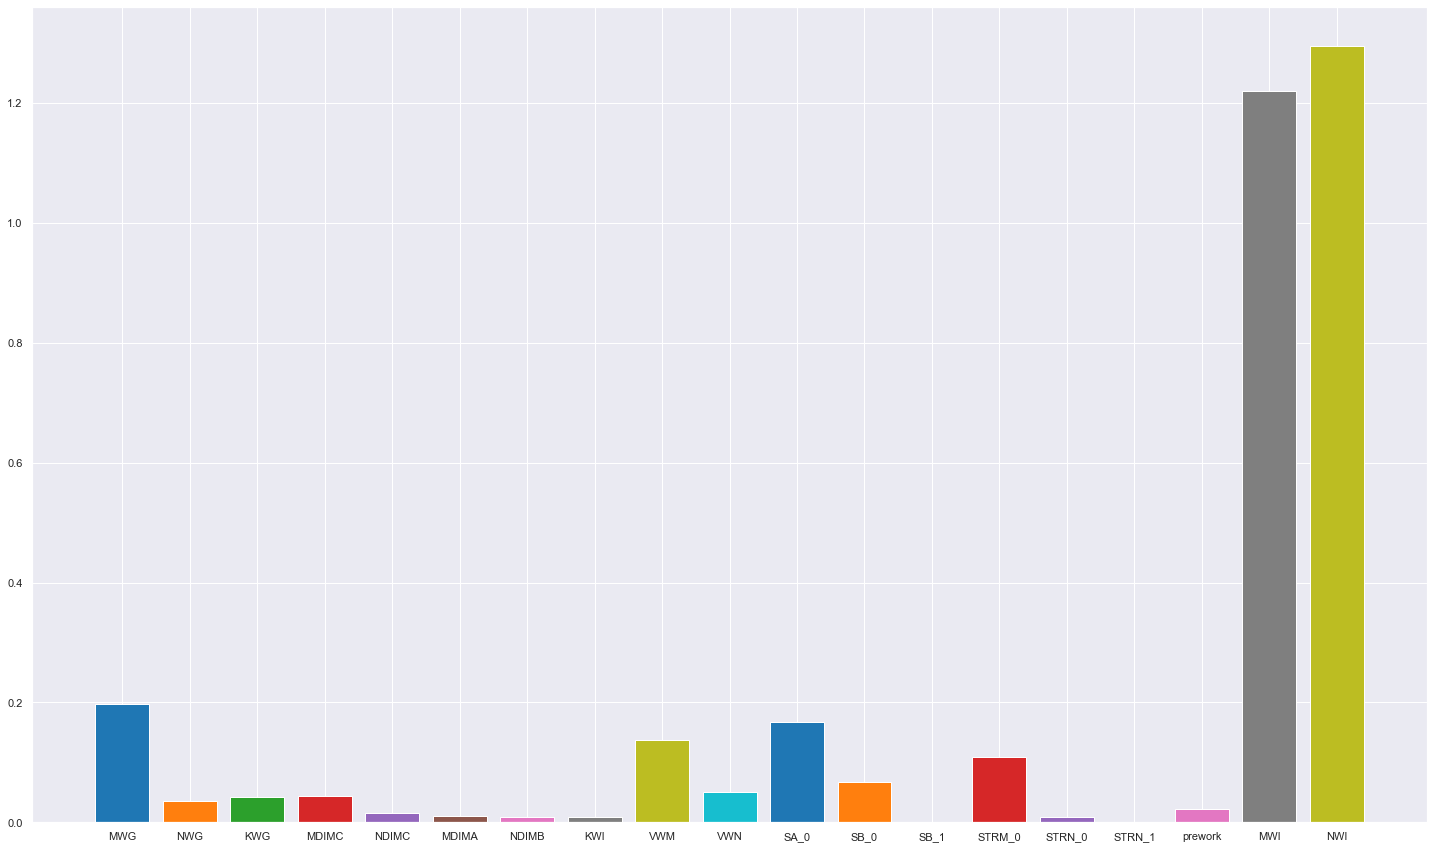

In [285]:
from sklearn.inspection import permutation_importance
results = permutation_importance(xgb, x1_train, y1_train, scoring='r2')
importance = results.importances_mean
    
coef_dict = {}
for coef, feat in zip(importance,all_features):
    coef_dict[feat] = coef  

cycol = cycle(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink',
              'tab:gray','tab:olive','tab:cyan'])
colors=[]
for i in range(0,len(all_features)):
    colors.append(next(cycol))

plt.figure(figsize=(25,15))
plt.bar(coef_dict.keys(),coef_dict.values(),color=colors) 

Comprovem la corba d'aprenentatge:

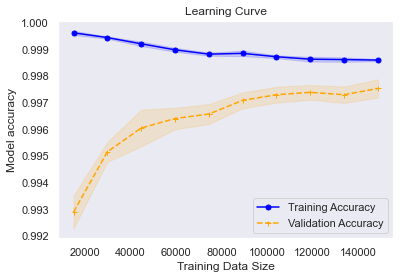

In [286]:
pipeline = make_pipeline(StandardScaler(),
                        XGBClassifier())
learning_curves(pipeline, x1_train, y1_train)

#### Resultats

Com el `XGboost` és el `Gradient Boosting` portat a l'extrem, ens ha millorat els resultats i altrement ha reduït el temps d'entrenament moltissim. D'aquesta manera podriem dir que és el model que millor s'adapta a les nostres dades. De la corba d'aprenentatge podem veure que no s'esta cometent cap tipus d'overfitting.

### Resultats

Dels tres classificadors aplicats em quedo amb el `XGBoost`, l'`accuracy` obtinguda es pràcticament perfecte, igual que amb totes les altres mètriques. A més a més el temps d'execució es molt baix respecte els altres classificadors. Podria comparar-lo amb el `Gradient Boosting` pels resultats de les mètriques però pel temps d'execució el `XGboost` és el més ràpid. Les taules de resultats serien les següents:

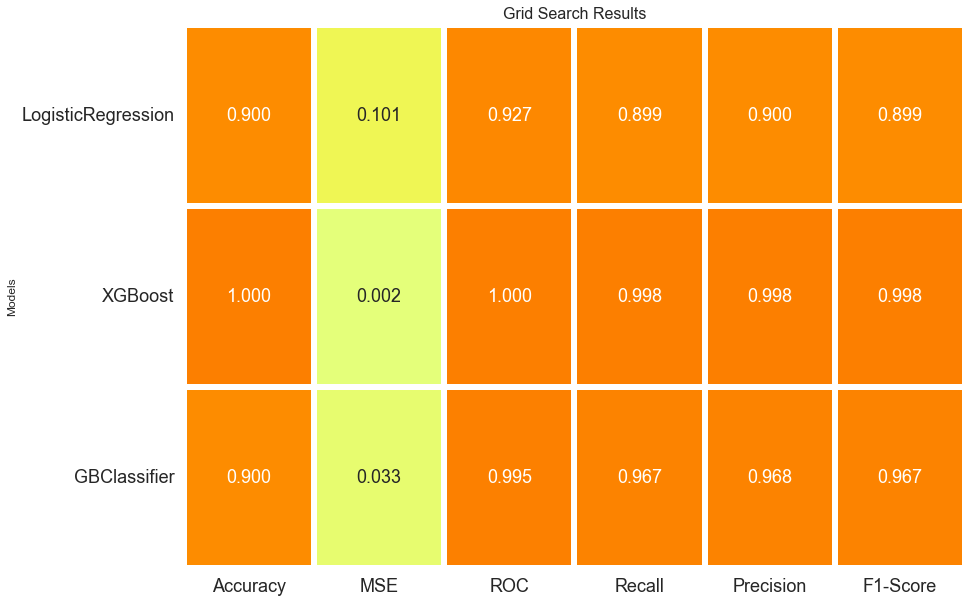

In [301]:
sns.set_style("darkgrid")
cv_results = pd.DataFrame({"Accuracy":cv_result,
                           "MSE":mean_squared_errors,
                           "ROC": roc_auc_scores,
                           "Recall": recall_scores,
                           "Precision": precision_scores,
                           "F1-Score":f1_scores,
                           "Models":["LogisticRegression", "XGBoost","GBClassifier",]})

cv_results.index = cv_results["Models"]

cv_results  = cv_results.drop(["Models"], axis = 1)

f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(cv_results, annot=True,cmap = "Wistia",fmt= '.3f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18})

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Grid Search Results", size = 16)
plt.show()

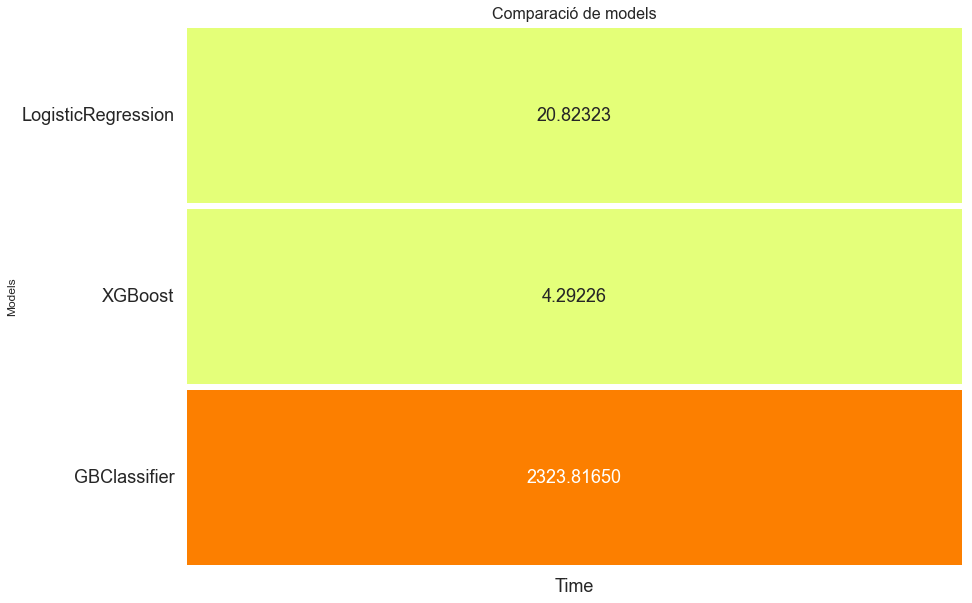

In [306]:
sns.set_style("darkgrid")
cv_results = pd.DataFrame({"Time": timec,
                           "Models":["LogisticRegression", "XGBoost","GBClassifier",
                                     ]})

cv_results.index = cv_results["Models"]

cv_results  = cv_results.drop(["Models"], axis = 1)

f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(cv_results, annot=True,cmap = "Wistia",fmt= '.5f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18})

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Comparació de models", size = 16)
plt.show()